# Using LDA and Logistic Regression Classifiers with Text

In this notebook we will apply `LogisticRegression` to our text classification
problem.

As the bag of words representation of a document is high dimensional we will use $\chi^2$ feature selection to select a subspace of a manageable dimension. 


## Preliminaries

### Imports

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# for a progress bar on slow calculations
from ipywidgets import IntProgress
from IPython.display import display

import sys
sys.path.append("../..")
from E4525_ML import plots
import E4525_ML.text as text
from E4525_ML.multiclass_logistic import LogisticGDClassifier
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots

In [2]:
seed=23
np.random.seed(seed)

### Data

#### Data Directories

In [3]:
raw_data_dir=r"../../raw/C50/C50train"
test_dir    =r"../../raw/C50/C50test"
data_dir=r"../../data/C50"


#### Corpus

In [4]:
documents_filename=data_dir+"/C50_documents.csv"
documents=pd.read_csv(documents_filename,index_col="document_id")
documents.head()

,filename,label
document_id,,
0,../../raw/C50/C50train/ScottHillis/253868newsM...,ScottHillis
1,../../raw/C50/C50train/ScottHillis/305692newsM...,ScottHillis
2,../../raw/C50/C50train/ScottHillis/340736newsM...,ScottHillis
3,../../raw/C50/C50train/ScottHillis/140340newsM...,ScottHillis
4,../../raw/C50/C50train/ScottHillis/126593newsM...,ScottHillis


In [5]:
test_documents_filename=data_dir+"/C50_test_documents.csv"
test_documents=pd.read_csv(test_documents_filename,index_col="document_id")
test_documents.head()

,filename,label
document_id,,
0,../../raw/C50/C50test/ScottHillis/373999newsML...,ScottHillis
1,../../raw/C50/C50test/ScottHillis/348602newsML...,ScottHillis
2,../../raw/C50/C50test/ScottHillis/387913newsML...,ScottHillis
3,../../raw/C50/C50test/ScottHillis/392527newsML...,ScottHillis
4,../../raw/C50/C50test/ScottHillis/417664newsML...,ScottHillis


In [6]:
scramble=True

In [7]:
if scramble:
    all_docs=pd.concat([documents,test_documents])
    print("all_docs.shape",all_docs.shape)
    msk=np.random.rand(len(all_docs))<0.5
    documents=all_docs[msk]
    test_documents=all_docs[~msk]
    print(documents.shape,test_documents.shape)

all_docs.shape (5000, 2)
(2584, 2) (2416, 2)



## Validation Set Creation

In [8]:
docs_train,docs_val,Y_train,Y_val=train_test_split(documents["filename"],documents["label"],test_size=0.2)

In [9]:
countVectorizer=CountVectorizer(input="filename",
                                       binary=True,
                                       tokenizer=text.stem_tokenizer,
                                       stop_words=[]) #text.stop_words())

## Select More important Features

In [10]:
F=1000

In [11]:
X=countVectorizer.fit_transform(docs_train)
Y=Y_train

In [12]:
V=X.shape[1]
V

27475

In [13]:
dummies=pd.get_dummies(Y,prefix="",prefix_sep="",sparse=True)
labels=dummies.columns
Z=dummies

In [14]:
transformer=SelectKBest(chi2,F) # get the best F based on chi2 metric

In [15]:
Xt=transformer.fit_transform(X,Z) # Return X with only the selected features

In [16]:
feature_idx=transformer.get_support(True)

In [17]:
index_2_word=countVectorizer.get_feature_names()

In [18]:
for idx in feature_idx[-10:]:
    print(idx,index_2_word[idx])

27328 yorkshir
27334 yoshinobu
27348 yuan
27359 yukon
27366 yuri
27369 yve
27394 zealand
27396 zedong
27400 zemin
27443 zinc


## LDA Text Classifier

### Train LDA Model

In [19]:
model=LinearDiscriminantAnalysis()

In [20]:
model.fit(Xt.toarray(),Y)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

We nearly fit the train data perfectly, are we overfitting?

In [21]:
Y_pred=model.predict(Xt)
np.mean(Y_pred==Y)

0.9840348330914369

### Validate LDA Model

In [22]:
X_val=countVectorizer.transform(docs_val)
Xt_val=transformer.transform(X_val)

Valuation performance is worse than Naive Bayes.


In [23]:
Y_pred=model.predict(Xt_val)
np.mean(Y_pred==Y_val)

0.6479690522243714

## Generic Text Classifier with Feature Selection

Selection $F$ features base of a $\chi^2$ test makes sense for any classifier.

For convenience we create a new wrapper classifier that selects $F$ features and calls the underlying
classier with them.

In [24]:
class TextChi2Classifier:
    def __init__(self,F,model):
        self.model=model
        self.transformer=SelectKBest(chi2,F)
    def fit(self,X,Y):
        dummies=pd.get_dummies(Y,prefix="",prefix_sep="",sparse=True)
        Z=dummies
        Xt=self.transformer.fit_transform(X,Z)
        self.model.fit(Xt,Y)
        return self
    def predict(self,X):
        Xt=self.transformer.transform(X)
        return self.model.predict(Xt)

In [25]:
modelT=TextChi2Classifier(F,model)

In [26]:
modelT.fit(X.toarray(),Y)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


We check that we still get the same answer as before

In [27]:
Y_pred=modelT.predict(X_val)
np.mean(Y_pred==Y_val)

0.6479690522243714

## LDA Classifier vs Number of Features 

With our new classifier is easy to test how well LDA does a a function of the number of features.

In [28]:
lda_base_model=LinearDiscriminantAnalysis()


In [29]:
Fs=[100,200,300,500,1000,2000,3000,5000,10000,20000,V]
#Fs=[10,20]

In [30]:
# Display a progress bar that counts how many training rounds we have done so far
progress= IntProgress(min=0, max=len(Fs),description="Trials:",bar_style="info")
display(progress)


lda_train_error=[]
lda_val_error=[]
lda_models=[]
progress.value=0
for F in Fs:
    model=TextChi2Classifier(F,lda_base_model)
    model.fit(X.toarray(),Y)
    lda_models.append(model)
    Y_pred=model.predict(X)
    lda_train_error.append(1-np.mean(Y_pred==Y))
    Y_pred=model.predict(X_val)
    lda_val_error.append(1-np.mean(Y_pred==Y_val))
    progress.value+=1
print("Done.")

IntProgress(value=0, bar_style='info', description='Trials:', max=11)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Done.


Text(0,0.5,'Classification Error')

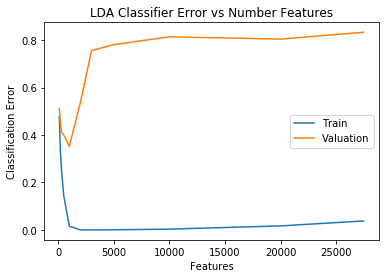

In [31]:
plt.plot(Fs,lda_train_error,label="Train")
plt.plot(Fs,lda_val_error,label="Valuation")
plt.legend()
plt.title("LDA Classifier Error vs Number Features")
plt.xlabel("Features")
plt.ylabel("Classification Error")

In [32]:
lda_best_idx=np.argmin(lda_val_error)
lda_best_model=lda_models[lda_best_idx]
lda_best_idx,Fs[lda_best_idx],lda_val_error[lda_best_idx]

(4, 1000, 0.3520309477756286)

1. Optional number of features is 1,000
1. After that, it overfits very quickly.
1. Optimal accuracy is 64% (34% error rate), close (but not quite as good) as the Naive Bayes Classifier
1. The difficulty is cause by fixing a $F\times F$ covariance matrix for the features. 

### Scramble train and test data

 ##  LogisticRegression Classifier vs Number of Features

In [33]:
logistic_base_model=LogisticRegression(C=1e40,solver="sag",multi_class="multinomial")
#logistic_base_model=LogisticGDClassifier(,max_iter=5000, learning_rate=0.005,tol=1e-8)

In [34]:
# Display a progress bar that counts how many training rounds we have done so far
progress2= IntProgress(min=0, max=len(Fs),description="Trials:",bar_style="info")
display(progress2)


logistic_train_error=[]
logistic_val_error=[]
progress2.value=0
for F in Fs:
    model=TextChi2Classifier(F,logistic_base_model)
    model.fit(X,Y)
    Y_pred=model.predict(X)
    logistic_train_error.append(1-np.mean(Y_pred==Y))
    Y_pred=model.predict(X_val)
    logistic_val_error.append(1-np.mean(Y_pred==Y_val))
    progress2.value+=1
print("Done.")

IntProgress(value=0, bar_style='info', description='Trials:', max=11)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done.


Text(0,0.5,'Classification Error')

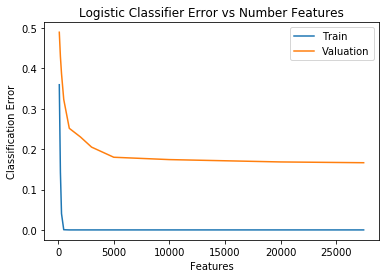

In [35]:
plt.plot(Fs,logistic_train_error,label="Train")
plt.plot(Fs,logistic_val_error,label="Valuation")
plt.legend()
plt.title("Logistic Classifier Error vs Number Features")
plt.xlabel("Features")
plt.ylabel("Classification Error")

In [36]:
logistic_best_idx=np.argmin(logistic_val_error)
logistic_best_idx,Fs[logistic_best_idx],logistic_val_error[logistic_best_idx]

(10, 27475, 0.16634429400386852)

1. The model is overfitting (training error is 0 after a few hundred Features)
2. Test Error stabilizes after roughtly 5k features
3. Logistic Regression performance does not degrade after we keep increasing the number of features

Best Accuracy is $\approx 84\%$, better than Naive Bayes

## Regularization of the Logistic Regression Classifier

In [37]:
F_best=5000 # Fs[logistic_best_idx] performance stabilizes after 5,000 features
F_best

5000

In [38]:
Cs=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000,1e10]

In [39]:
class CountFitter:
    def __init__(self,base_model,countVectorizer,F):
        model=TextChi2Classifier(F,base_model)
        self.model=model
        self.countVectorizer=countVectorizer
    def fit(self,X,Y):
        x=self.countVectorizer.fit_transform(X)
        #print("x.shape",x.shape)
        return self.model.fit(x,Y)
    def predict(self,X):
        x=self.countVectorizer.transform(X)
        #print("x.shape",x.shape)
        return self.model.predict(x)

In [40]:
def validate_model(model,K,X,Y):
    X=np.copy(X)
    Y=np.copy(Y)
    folder=KFold(K,shuffle=True)
    folds=folder.split(X,Y)
    val_error=0.0
    fold_count=0
    for fold in folds:
        train_idx,val_idx=fold
        x_train=X[train_idx]
        y_train=Y[train_idx]
        x_val=X[val_idx]
        y_val=Y[val_idx]     
        model.fit(x_train,y_train)
        y_pred=model.predict(x_val)
        val_err=np.mean(y_val==y_pred)
        #print(y_pred)
        val_error+=val_err
        fold_count+=1
        print("    ",fold_count,val_err)
    return val_error/K


In [41]:
K=5

In [42]:
# Display a progress bar that counts how many training rounds we have done so far
progress3= IntProgress(min=0, max=len(Cs),description="Trials:",bar_style="info")
display(progress3)

logistic_val_error=[]
progress3.value=0
for C in Cs:
    base_model=LogisticRegression(C=C,solver="sag",multi_class="multinomial")
    model=CountFitter(base_model,countVectorizer,F_best)
    acc=validate_model(model,K,documents["filename"],documents["label"])
    logistic_val_error.append(1-acc)
    print(C,1-acc)
    progress3.value+=1
print("Done.")

IntProgress(value=0, bar_style='info', description='Trials:', max=10)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


     1 0.16827852998065765
     2 0.23404255319148937
     3 0.08704061895551257
     4 0.06382978723404255
     5 0.17054263565891473
0.0001 0.8552531749958766
     1 0.6015473887814313
     2 0.5222437137330754
     3 0.528046421663443
     4 0.5357833655705996
     5 0.5717054263565892
0.001 0.4481347367789723
     1 0.7620889748549323
     2 0.7872340425531915
     3 0.793036750483559
     4 0.746615087040619
     5 0.7635658914728682
0.01 0.22949185071896605
     1 0.8220502901353965
     2 0.8201160541586073
     3 0.8278529980657641
     4 0.8297872340425532
     5 0.8255813953488372
0.1 0.17492240564976846
     1 0.7911025145067698
     2 0.8297872340425532
     3 0.8529980657640233
     4 0.8588007736943907
     5 0.8372093023255814
1 0.16602042193333644
     1 0.8181818181818182
     2 0.839458413926499
     3 0.8201160541586073
     4 0.8278529980657641
     5 0.8333333333333334
10 0.1722114764667957
     1 0.8239845261121856
     2 0.851063829787234
     3 0.825918762088974

In [43]:
logistic_val_error=np.array(logistic_val_error)
print("C,error")
for idx,C in enumerate(Cs):
    print(C,logistic_val_error[idx])

C,error
0.0001 0.8552531749958766
0.001 0.4481347367789723
0.01 0.22949185071896605
0.1 0.17492240564976846
1 0.16602042193333644
10 0.1722114764667957
100 0.16834375421708425
1000 0.17646529620799778
10000 0.17491640801883257
10000000000.0 0.17415320948225455


In [44]:
best_idx=logistic_val_error.argmin()
best_C=Cs[best_idx]
print(best_idx,best_C,logistic_val_error[best_idx])

4 1 0.16602042193333644


## Test best model

Best model is logistic regression, with C=100 used on all features

In [45]:
Y_test=test_documents["label"]

In [46]:
base_model=LogisticRegression(C=best_C,solver="sag",multi_class="multinomial")
model=CountFitter(base_model,countVectorizer,F_best)

In [47]:
model.fit(documents["filename"],documents["label"])

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [48]:
Y_pred=model.predict(test_documents["filename"])
np.mean(Y_pred==Y_test)

0.8439569536423841

In [49]:
classes=np.unique(Y_test.as_matrix())

Confusion matrix, without normalization
[[50  0  0 ...  0  0  0]
 [ 0 40  0 ...  0  0  0]
 [ 0  0 37 ...  1  0  0]
 ...
 [ 0  0  0 ... 44  0  0]
 [ 0  0  0 ...  0 42  0]
 [ 0  0  0 ...  0  0 27]]


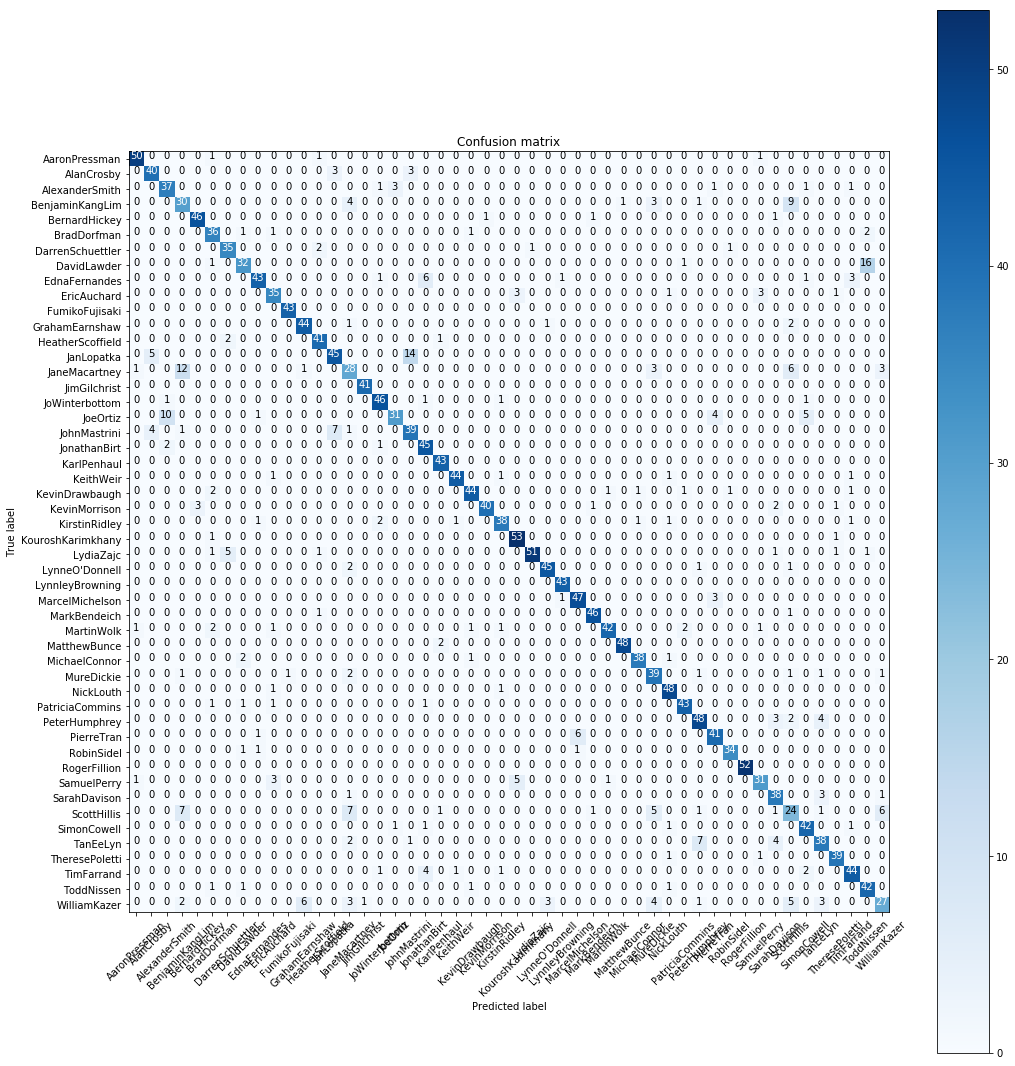

In [50]:
plt.figure(figsize=(15,15))
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)
plots.plot_confusion_matrix(cnf_matrix,classes)